In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('../data/processed/datasers_merged_cleaned.csv') 

In [4]:
df.head()

,producto,medida_cantidad,medida_unidad,supermercado,costo,anio,mes,cadena,supermercado_id,producto_id,cadena_id
0,ACEITE VEGETAL NACIONAL,1.42,Litros,RIBA SMITH BELLA VISTA,3.85,2020,2,RIBA SMITH,74,0,5
1,ACEITE VEGETAL NACIONAL,1.42,Litros,RIBA SMITH TRANSISTMICA,3.15,2020,2,RIBA SMITH,75,0,5
2,ACEITE VEGETAL NACIONAL,1.42,Litros,SUPER 99 CAMINO REAL,3.89,2020,2,SUPER 99,78,0,6
3,ACEITE VEGETAL NACIONAL,1.42,Litros,SUPER 99 EL DORADO,3.89,2020,2,SUPER 99,80,0,6
4,ACEITE VEGETAL NACIONAL,1.42,Litros,SUPER 99 TUMBA MUERTO,2.49,2020,2,SUPER 99,92,0,6


### Modelos de Regresión

#### Evaluar modelo de regresión Ridge

In [5]:
from sklearn.preprocessing import StandardScaler

def entrenar_ridge(df=df):
    # Seleccionar todas las columnas numéricas excepto 'costo'
    # Usamos todas las columnas numéricas excepto 'costo', en este caso no ncesesitamos One-Hot Encoding
    features = df.select_dtypes(include=[np.number]).drop(columns=['costo'])
    X = features
    y = df['costo']
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    
    # Entrenar modelo Ridge con todos los datos de entrenamiento
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'WMAPE': wmape
    }

In [ ]:
metricas = []
tmp_metr = entrenar_ridge(df=df)
tmp_metr['Modelo'] = 'Ridge'
metricas.append(tmp_metr)

In [11]:
def entrenar_ridge_por_cadena(df, cadena_id):
    # Filtrar el dataframe por cadena_id
    df_filtrado = df[df['cadena_id'] == cadena_id]
    
    # Seleccionar todas las columnas numéricas excepto 'costo'
    features = df_filtrado.select_dtypes(include=[np.number]).drop(columns=['costo'])
    X = features
    y = df_filtrado['costo']
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Entrenar modelo Ridge con los datos filtrados
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))
    
    metricas = {
        'MAE': mae,
        'RMSE': rmse,
        'WMAPE': wmape
    }
    
    return model, metricas

In [14]:

metricas_cadena = []
modelos_cadena = {}
for cadena_id in df['cadena_id'].unique():
    model, metricas = entrenar_ridge_por_cadena(df, cadena_id)
    cadena_nombre = df[df['cadena_id'] == cadena_id]['cadena'].iloc[0]
    metricas_cadena.append((cadena_id, cadena_nombre, metricas))
    modelos_cadena[cadena_id] = model

# Almacenar todas las métricas en un DataFrame
df_metricas = pd.DataFrame(metricas_cadena, columns=['cadena_id', 'cadena', 'metricas'])
df_metricas.head()

,cadena_id,cadena,metricas
0,5,RIBA SMITH,"{'MAE': 1.7010811032009994, 'RMSE': 2.23280775..."
1,6,SUPER 99,"{'MAE': 1.6073319258626861, 'RMSE': 2.22567421..."
2,7,XTRA,"{'MAE': 1.6038858150859383, 'RMSE': 2.21627623..."
3,2,EL MACHETAZO,"{'MAE': 1.6483511849917025, 'RMSE': 2.24307884..."
4,4,REY,"{'MAE': 1.6834558537779039, 'RMSE': 2.32556164..."


In [15]:
def predecir_precio_por_cadena(datos_nuevos, modelos_cadena):
    """
    Predice el precio usando el modelo Ridge entrenado por cadena para datos nuevos.
    datos_nuevos: DataFrame con los mismos features que el entrenamiento, incluyendo 'cadena_id'.
    modelos_cadena: dict con modelos Ridge por cadena_id.
    Retorna: Serie con predicciones de precio.
    """
    # Seleccionar columnas numéricas excepto 'costo'
    features = datos_nuevos.select_dtypes(include=[np.number]).drop(columns=['costo'], errors='ignore')
    predicciones = []
    
    for idx, row in datos_nuevos.iterrows():
        cadena_id = row['cadena_id']
        modelo = modelos_cadena.get(cadena_id)
        if modelo is not None:
            # Escalar usando media y std del propio dato (solo para ejemplo, idealmente usar scaler del entrenamiento)
            X = row[features.columns].values.reshape(1, -1)
            pred = modelo.predict(X)[0]
        else:
            pred = np.nan
        predicciones.append(pred)
    
    return pd.Series(predicciones, index=datos_nuevos.index, name='precio_predicho')

In [16]:
# Ejemplo de uso: llamar a la función predecir_precio_por_cadena con datos del DataFrame original
# Seleccionamos algunas filas de ejemplo para predecir
datos_nuevos = df.sample(5, random_state=42)
predicciones = predecir_precio_por_cadena(datos_nuevos, modelos_cadena)
print(predicciones)

44027     40.091481
1246      79.870637
5716     127.757238
20465   -243.207289
30855    -32.522711
Name: precio_predicho, dtype: float64


#### Modeo de regresión Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def evaluar_random_forest(df=df):
    # Usamos todas las columnas numéricas excepto 'costo', en este caso no ncesesitamos One-Hot Encoding
    features = df.select_dtypes(include=[np.number]).drop(columns=['costo'])
    X = features
    y = df['costo']
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Modelo Random Forest
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'WMAPE': wmape
    }

In [ ]:
tmp_metr = evaluar_random_forest(df=df)
tmp_metr['Modelo'] = 'Random Forest'
metricas.append(tmp_metr)

#### Modelo HistGradientBoostingRegressor.

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

def evaluar_hist_gradient_boosting(df=df):
    # Usamos todas las columnas numéricas excepto 'costo'
    features = df.select_dtypes(include=[np.number]).drop(columns=['costo'])
    X = features
    y = df['costo']
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Modelo HistGradientBoostingRegressor
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'WMAPE': wmape
    }

In [ ]:
tmp_metr = evaluar_hist_gradient_boosting(df=df)
tmp_metr['Modelo'] = 'HistGradient Boosting'
metricas.append(tmp_metr)

#### Tabla comparativa

In [ ]:
metricas_df = pd.DataFrame(metricas)
metricas_df.set_index('Modelo', inplace=True)
display(metricas_df)

,MAE,RMSE,WMAPE
Modelo,,,
Ridge,1.499736,2.079326,0.634666
Random Forest,0.157176,0.345351,0.066515
HistGradient Boosting,0.219950,0.378114,0.093080


Las métricas que usas se interpretan así:

MAE (Mean Absolute Error):
Es el promedio de los errores absolutos entre los valores reales y los predichos. Indica, en promedio, cuánto se equivoca el modelo.
Más bajo es mejor.

RMSE (Root Mean Squared Error):
Es la raíz cuadrada del promedio de los errores al cuadrado. Penaliza más los errores grandes.
Más bajo es mejor.

WMAPE (Weighted Mean Absolute Percentage Error):
Es el error absoluto medio dividido por la suma de los valores reales. Indica el error relativo respecto al total observado.
Más bajo es mejor; útil para comparar entre diferentes escalas.

En resumen: valores bajos en estas métricas indican mejor desempeño del modelo.

----------------------------------------------------------------
Como podemos observar el modelo Random Forest es el que mejor desempleño consigue con las metricas de errores más bajas.

En el análisis de matriz de correlación observamos poca releacion entre las variables. Random forest funciona mejor cuando el problema tiene relaciones no lineales o variables categoricas con multipolles niveles (muy variada). 

### Modelos de clasificaión. 

Modelo baseline Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

def evaluar_naive_bayes(df):
    # Usamos todas las columnas numéricas excepto 'costo'
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Binarizar costo (clasificación)
    # Utilizo la mediana como umbral para binarizar la variable objetivo
    umbral = df["costo"].median()
    df["costo_bin"] = (df["costo"] > umbral).astype(int)
    
    X = df[num_cols].drop(columns=["costo"])
    y = df["costo_bin"]
    
    
    # Split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Modelo Naive Bayes
    model = GaussianNB()
    model.fit(X_train_scaled, y_train)
    
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker="o", label="Naive Bayes")
    plt.plot([0,1],[0,1], linestyle="--", color="gray", label="Perfecto calibrado")
    plt.xlabel("Probabilidad media predicha")
    plt.ylabel("Proporción positiva real")
    plt.title("Curva de Calibración - Naive Bayes")
    plt.legend()
    plt.show()
    
    return {
        'Model': 'Naive Bayes',
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    }
    

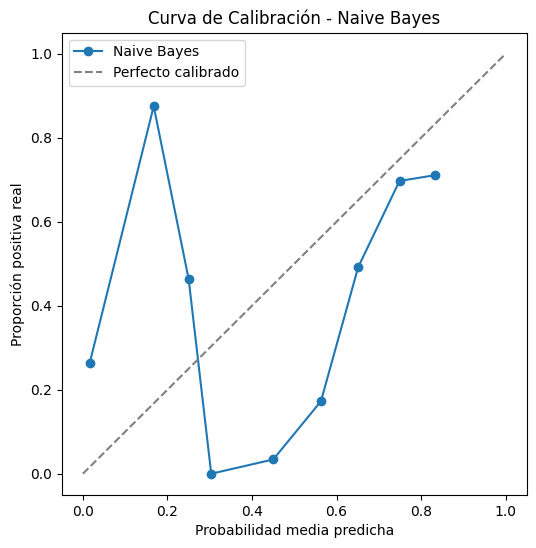

{'Model': 'Naive Bayes',
 'ROC AUC': 0.7254617765870878,
 'PR AUC': 0.6795978540983376}

In [ ]:
evaluar_naive_bayes(df)

En el entrenamiento del modelo se define un umbral (mediana del precio) para clasificar de forma binaria (precio alto o precio bajo) los datos.

Este es un enfoque distinto ya que al principio se propuso utilizar el modelo de clasificacion para alertar por cambio de precio. Para este enfoque solo necesitamos comparar el precioo anterior para darnos cuanta de un cambio de precio y no requerimos de un modelo de clasificacion para este objetivo.

Con respecto a las metricas de evaluación tenemos que ambas (ROC AUS y PR AUC) tienen valores superiores a 0.5 lo que nos indica un desempeño mejor que la aleatoriedad.
